In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from fleck import generate_spots, Stars
from scipy.stats import ks_2samp, anderson_ksamp

Load observed smoothed-amplitude distribution for comparison, plot it: 

In [19]:
#amps_fast = 2 * np.loadtxt('data/amps_fast.txt')
amps_fast = 2 * np.loadtxt('data/cluster_fast.txt')
amps_slow = 2 * np.loadtxt('data/cluster_slow.txt')
amps_superfast = 2 * np.loadtxt('data/cluster_superfast.txt')

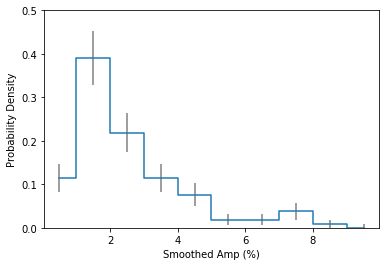

In [12]:
def norm_hist(x):
    n_bins = 10
    bin_range = [0, 10.0]
    freq, bin_edges = np.histogram(x, bins=n_bins, range=bin_range)
    bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
    dx = bin_edges[1] - bin_edges[0]
    norm = np.sum(freq * dx)
    normalized_freq = freq/norm
    normalized_freq_err = np.max([np.sqrt(freq)/norm, np.ones_like(freq)/norm], axis=0)
    return bin_centers, normalized_freq, normalized_freq_err

bin_centers, normalized_freq, normalized_freq_err = norm_hist(amps_fast)
plt.errorbar(bin_centers, normalized_freq, normalized_freq_err, 
             ls='steps-mid', ecolor='gray')
plt.ylim([0, 0.5])
plt.xlabel('Smoothed Amp (%)')
plt.ylabel('Probability Density')
plt.show()

Set up some intial properties of the star: 

In [13]:
ld = [0.5079, 0.2239]
stars = Stars(spot_contrast=0.7, n_phases=30, u_ld=ld)
n_inclinations = 50
spot_radius = 0.2
n_spots = 3
min_smoothed_amp = 0.01336
stars = Stars(spot_contrast=0.7, n_phases=30, u_ld=ld)

At each step in the chain, run function `ad`, which generates an ensemble of simulated smoothed-amplitudes for comparison with the observed distribution of smoothed amplitudes. Compute distance between the observed and simulated samples using the two-sample Anderson-Darling statistic.

In [36]:
def ad(spot_radius, min_latitude, spot_contrast):
    stars.spot_contrast = spot_contrast
    lons, lats, rads, incs = generate_spots(min_latitude=min_latitude, max_latitude=90, n_spots=n_spots,
                                            spot_radius=spot_radius, n_inclinations=n_inclinations)
    lcs = stars.light_curves(lons, lats, rads, incs)
    smoothed_amps = 100 * lcs.ptp(axis=0)
    smoothed_amps = smoothed_amps[smoothed_amps > min_smoothed_amp]
    if len(smoothed_amps) < 1: 
        anderson_stat = 100
    else: 
        anderson_stat = anderson_ksamp([smoothed_amps, amps_fast]).statistic
    return anderson_stat

n_steps = 50000
init_rad = 0.23
init_min_lat = 70
init_contrast = 0.7

Set initial conditions for the chains: 

In [37]:
p_values = [ad(init_rad, init_min_lat, init_contrast)]
spot_radii = [init_rad]
min_lats = [init_min_lat]
spot_contrasts = [init_contrast]
steps = 0
accepted_step = 0

For `n_steps`: 

1. Propose a new step by randomly perturbing the previous step's parameters
2. Compute the Anderson-Darling statistic for the new step
3. If A-D statistic < 1: accept the step
4. Append accepted step to the list of samples, return to (1)

In [38]:
while accepted_step < n_steps: 
    
    spot_radius = 0.05 * np.random.randn() + spot_radii[accepted_step-1]
    min_lat = 5*np.random.randn() + min_lats[accepted_step-1]
    spot_contrast = 0.1*np.random.randn() + spot_contrasts[accepted_step-1]
    
    # Apply prior
    if 0 < spot_radius < 1 and 0 < min_lat < 90 and 0 < spot_contrast < 1:
        adstat = ad(spot_radius, min_lat, spot_contrast)

        steps += 1
        if adstat < 1: 
            # Accept step
            spot_radii.append(spot_radius)
            min_lats.append(min_lat)
            spot_contrasts.append(spot_contrast)
            p_values.append(adstat)
            accepted_step += 1

In [39]:
print('acceptance rate:', accepted_step/steps)

acceptance rate: 0.12398179947183753


Plot each chain: 

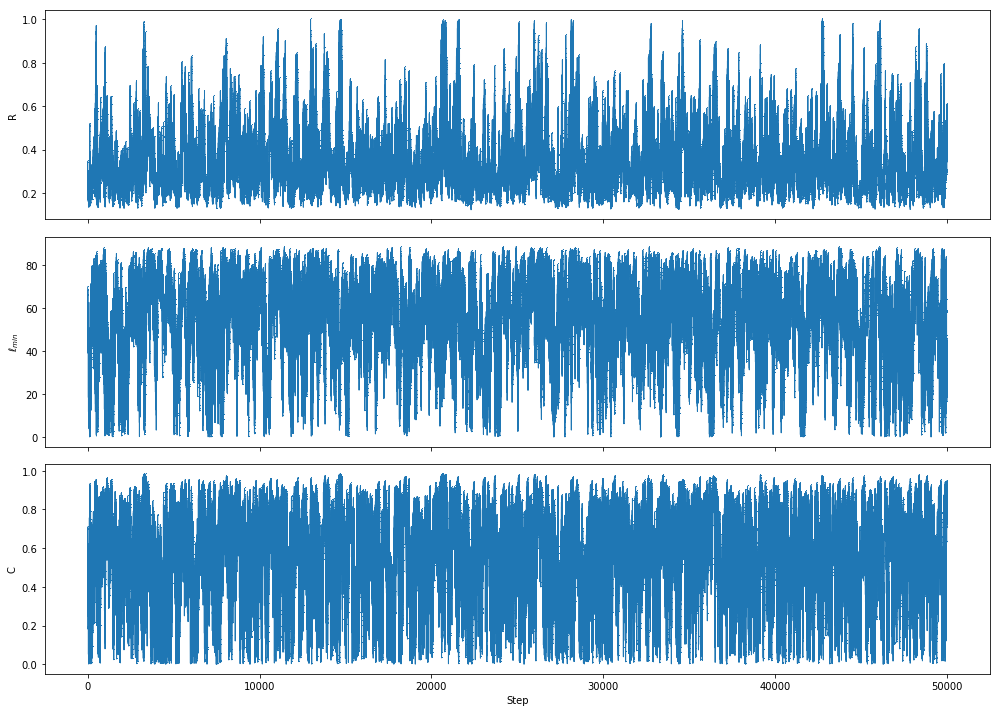

In [40]:
fig, ax = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
ax[0].plot(spot_radii, marker=',', lw=1)
ax[1].plot(min_lats, marker=',', lw=1)
ax[2].plot(spot_contrasts, marker=',', lw=1)
# ax[3].plot(p_values, marker=',', lw=0)

titles = ['R', '$\ell_{min}$', "C", '']
for axis, title in zip(ax, titles):
    axis.set_ylabel(title)
ax[-1].set_xlabel('Step')
fig.tight_layout()
# ax[2].set_ylim([-2, 3])

In [15]:
plt.hist(p_value);

NameError: name 'p_value' is not defined

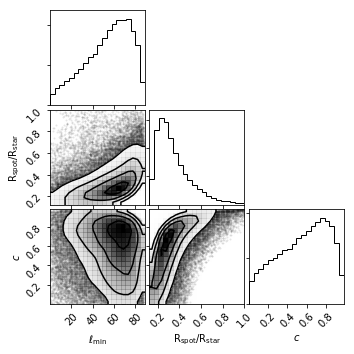

In [41]:
from corner import corner

fig, ax = plt.subplots(3, 3, figsize=(5, 5))
samples = np.array([min_lats, spot_radii, spot_contrasts]).T
corner(samples, labels='$\\rm\ell_{min}$ $\\rmR_{spot}/R_{star}$ $c$'.split(), smooth=True, fig=fig);
# fig.tight_layout()
plt.savefig('plots/corner_fast.pdf', bbox_inches='tight')

In [42]:
# samples = np.array([np.log10(90-np.array(min_lats)), np.log10(spot_radii), np.log(1-np.array(spot_contrasts))]).T
# corner(samples, labels='$\\rm\ell_{min}$ $\\rmR_{spot}/R_{star}$ $c$'.split());

In [43]:
np.save('data/abc_samples_fast.npy', samples)

fs_fast = $2.50_{-1.42}^{+3.27}$
fs_slow = $1.60_{-1.00}^{+2.67}$
fs_superfast = $0.60_{-0.43}^{+1.48}$


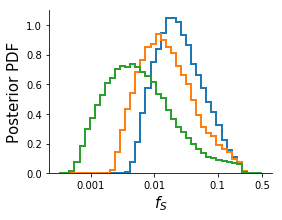

In [4]:
samples_superfast = np.load('data/abc_samples_superfast.npy')
samples_fast = np.load('data/abc_samples_fast.npy')
samples_slow = np.load('data/abc_samples_slow.npy')

fs_fast = np.pi * samples_fast[:, 1]**2 / (4*np.pi)
fs_slow = np.pi * samples_slow[:, 1]**2 / (4*np.pi)
fs_superfast = np.pi * samples_superfast[:, 1]**2 / (4*np.pi)


bins = 40
bin_range = [-3.5, np.log10(0.5)]#[0.001, 0.1]
fig, ax = plt.subplots(figsize=(4, 3))
ax.hist(np.log10(fs_fast), bins=bins, alpha=1, density=True, range=bin_range, 
        label='EPIC 210490365', histtype='step', lw=2);
ax.hist(np.log10(fs_slow), bins=bins, alpha=1,  density=True, range=bin_range, 
        label='EPIC 211916756', histtype='step', lw=2);
ax.hist(np.log10(fs_superfast), bins=bins, alpha=1, density=True, range=bin_range, 
        histtype='step', lw=2);

mu_fast, std_fast =  np.log10(fs_fast).mean(), np.log10(fs_fast).std()
mu_slow, std_slow =  np.log10(fs_slow).mean(), np.log10(fs_slow).std()
mu_superfast, std_superfast =  np.log10(fs_superfast).mean(), np.log10(fs_superfast).std()

mid_fast, lower_fast, upper_fast = 100 * 10**(mu_fast), 100 * 10**(mu_fast-std_fast), 100 * 10**(mu_fast+std_fast)
mid_slow, lower_slow, upper_slow = 100 * 10**(mu_slow), 100 * 10**(mu_slow-std_slow), 100 * 10**(mu_slow+std_slow)
mid_superfast, lower_superfast, upper_superfast = 100 * 10**(mu_superfast), 100 * 10**(mu_superfast-std_superfast), 100 * 10**(mu_superfast+std_superfast)

print('fs_fast = ${0:.2f}_{{-{1:.2f}}}^{{+{2:.2f}}}$'.format(mid_fast, mid_fast-lower_fast, upper_fast-mid_fast))
print('fs_slow = ${0:.2f}_{{-{1:.2f}}}^{{+{2:.2f}}}$'.format(mid_slow, mid_slow-lower_slow, upper_slow-mid_slow))
print('fs_superfast = ${0:.2f}_{{-{1:.2f}}}^{{+{2:.2f}}}$'.format(mid_superfast, mid_superfast-lower_superfast, upper_superfast-mid_superfast))

# ax.legend(loc='upper left', bbox_to_anchor=(0.5, 1.3))
for s in ['right', 'top']: 
    ax.spines[s].set_visible(False)
fs = 15
ax.set_xlabel('$f_S$', fontsize=fs)
ax.set_ylabel('Posterior PDF', fontsize=fs)
ax.set_xticks([-3, -2, -1, np.log10(0.5)])
ax.set_xticklabels(['0.001', '0.01', '0.1', '0.5'])

# lower, mid, upper = np.percentile(fs, [14, 50, 84])
# freqs, bins, _ = plt.hist(fs, bins=100);
# bin_centers = 0.5 * (bins[:-1] + bins[1:])

# # plt.hist(fs, bins=100)
# plt.axvline(bin_centers[np.argmax(freqs)], color='k')
# plt.axvline(upper, color='k')
plt.savefig('plots/fs_posterior.pdf', bbox_inches='tight')

In [5]:
samples_fast.shape

(50001, 3)

In [6]:
# best_sample_superfast = np.load('data/abc_samples_superfast_minAD.npy')
# best_sample_fast = np.load('data/abc_samples_fast_minAD.npy')
# best_sample_slow = np.load('data/abc_samples_slow_minAD.npy')

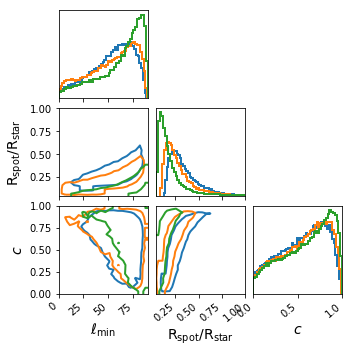

In [7]:
from corner import hist2d

fig, ax = plt.subplots(3, 3, figsize=(5, 5), sharex='col')

all_samples = [samples_fast, 
               samples_slow, 
               samples_superfast]

nbins = 50
colors = ['C0', 'C1', 'C2']
labels = '$\\rm\ell_{min}$ $\\rmR_{spot}/R_{star}$ $c$'.split()
limits = [[0, 90], [0, 1], [0, 1]]
fontsize = 14

for i in range(3):
    for j in range(3): 
        ax[j, i].set_xlim(limits[j])
        plt.setp(ax[j, i].get_xticklabels(), rotation=40, ha='right')
        for k in range(len(all_samples)):
            if i > j: 
                ax[j, i].axis('off')
            if i == j: 
                ax[j, i].hist(all_samples[k][:, i], histtype='step', bins=nbins, color=colors[k], lw=2)
                ax[j, i].set_yticks([])
        
            if i < j: 
                hist2d(all_samples[k][:, i], all_samples[k][:, j],  ax=ax[j, i], smooth=False,
                       plot_datapoints=False, fill_contours=False, plot_density=False, 
                       contour_kwargs=dict(colors=colors[k], linewidths=2), levels=[0.67534753], 
                       contourf_kwargs=dict(colors=colors[k], alpha=0.1))
#                 if best_samples[k] is not None:
#                     ax[j, i].scatter(best_samples[k][i], best_samples[k][j], color=colors[k])
            if j == 2:
                ax[j, i].set_xlabel(labels[i], fontsize=fontsize)
            if i == 0 and j > 0: 
                ax[j, i].set_ylabel(labels[j], fontsize=fontsize)
ax[2, 1].set_yticks([])
fig.tight_layout(h_pad=0, w_pad=-1.8)
fig.savefig('plots/corner_all.pdf', bbox_inches='tight')

$\rm\ell_{min}$MAP =  84.3201160754
$\rmR_{spot}/R_{star}$MAP =  0.0999429039668
$c$MAP =  0.8852410004
$\rm\ell_{min}$MAP =  72.1365409914
$\rmR_{spot}/R_{star}$MAP =  0.24277629747
$c$MAP =  0.750269142304
$\rm\ell_{min}$MAP =  74.945183926
$\rmR_{spot}/R_{star}$MAP =  0.167717518359
$c$MAP =  0.85397916809


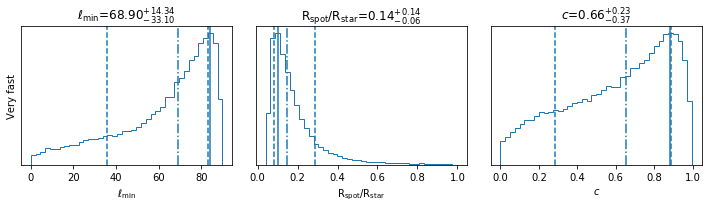

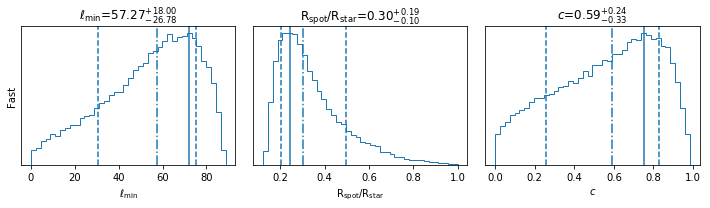

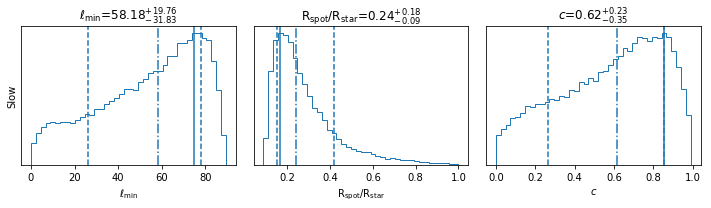

In [8]:
from astropy.table import Table
nbins = 40

table_rows = []

all_samples = [samples_superfast,
               samples_fast, 
               samples_slow]

names = ['Very fast', 'Fast', 'Slow']

for k in range(len(all_samples)):
    fig, ax = plt.subplots(1, 3, figsize=(10, 3))
    row = [names[k]]
    ax[0].set_ylabel(names[k])
    for j in range(3):
        x = all_samples[k][:, j]
        f, e, p = ax[j].hist(x, bins=nbins, histtype='step');
        
        lower, mid, upper = np.percentile(x, [16, 50, 84])
        credible = "${{{0:.2f}}}_{{-{1:.2f}}}^{{+{2:.2f}}}$".format(mid, mid-lower, upper-mid)
        bin_centers = 0.5*(e[1:] + e[:-1])
        map_estimate = bin_centers[np.argmax(f)]
        print(labels[j]+"MAP = ",map_estimate)
        row.append(credible)
        ax[j].set_title(labels[j]+"="+credible)
        ax[j].axvline(map_estimate)
        ax[j].axvline(lower, ls='--')
        ax[j].axvline(mid, ls='-.')
        ax[j].axvline(upper, ls='--')
        ax[j].set_yticks([])
        ax[j].set_xlabel(labels[j])
    fig.tight_layout()
    table_rows.append(row)

In [12]:
results = Table(rows=table_rows, names='Sample $\ell_{min}$ $R_{spot}/R_{star}$ $c$'.split())
results.write('data/abc_results.tex', overwrite=True)

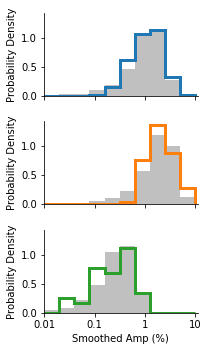

In [66]:
binrange = np.log10([0.01, 10]) #[-4, 3] # [0, 8]


all_samples = [samples_slow,
               samples_fast, 
               samples_superfast]

measured_amps = [amps_slow, 
                 amps_fast, 
                 amps_superfast]

colors = ['C0', 'C1', 'C2']

fig, ax = plt.subplots(3, 1, figsize=(3, 5), sharex=True, sharey=True)

for k in range(len(all_samples)):
    min_lat, rspot, c = np.median(all_samples[k], axis=0)
    n_inclinations = 5000
    n_spots = 3
    rads = rspot * np.ones((n_spots, n_inclinations))
    lats = ((90 - min_lat)*np.random.rand(n_spots, n_inclinations) + min_lat) * u.deg
    lons = 360 * np.random.rand(n_spots, n_inclinations) * u.deg
    incs = (180*np.random.rand(n_inclinations) - 90) * u.deg
    
    lcs = stars.light_curves(lons, lats, rads, incs)
    ax[k].hist(np.log10(100 * lcs.ptp(axis=0)), range=binrange, density=True, histtype='stepfilled', lw=3, color='silver')
    ax[k].hist(np.log10(measured_amps[k]), range=binrange, density=True, histtype='step', lw=3, color=colors[k])

    for s in ['right', 'top']: 
        ax[k].spines[s].set_visible(False)

    ax[k].set_xlim(np.log10([0.01, 10]))
    xticks = np.array(ax[k].get_xticks())
    ax[k].set_xticks(xticks)
    ax[k].set_xticklabels(["{0:.2g}".format(i) for i in 10**xticks])
    ax[k].set_ylabel('Probability Density')
    ax[k].set_xlim(np.log10([0.01, 11]))
ax[-1].set_xlabel("Smoothed Amp (%)")
fig.tight_layout()
fig.savefig('plots/model_smamps.pdf', bbox_inches='tight')
plt.show()